# 2D Preprocessing example
Notebook used to preprocess DESI Spectra into 2D images and dump them into pickled files. 

In [1]:
import numpy as np
from desispec.io import read_spectra
from desispec.interpolation import resample_flux
from glob import glob
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, hstack

import os
import platform

import pickle

 Couldn't install DESITRIP package on NERSC hence rescale and rebin code written below

## Functions

In [2]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray y 
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
          
    return (flux - a) / (b - a)

In [3]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=1, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)

    return basewave, fl, iv

In [4]:
def condition_spectra(files, fullvariable, num_bins):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None


    for f in files:

        spectra = read_spectra(f)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(f, 'EXTRA_CATALOG')
        truez = truth['Z']

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=3600., maxwave=9800., nbins=num_bins, log=False, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    #
    if fullvariable:
        return fluxes,rewave,reflux,wave,flux,ivar
    else:
        return fluxes

In [5]:
def to_2d(flux):
    
    return_flux=[]
    for i in range(len(flux)):
        trial=flux[i][0:6421]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(60,60)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux



In [6]:
def median_norm(flux):
    median = np.median(flux)
    norm_flux = flux / median
    
    return norm_flux

### sky lines

In [7]:
skylinesb = Table.read('peak_wavelengths_b.csv')
skylinesb = skylinesb['Wavelength']

skylinesr = Table.read('peak_wavelengths_r.csv')
skylinesr = skylinesr['Wavelength']

skylinesz = Table.read('peak_wavelengths_z.csv')
skylinesz = skylinesz['Wavelength']

skylines = np.concatenate((skylinesb, skylinesr, skylinesz))

lenses = Table.read('sim-lenses-10000-zonly-slimmed.fits')

In [8]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [9]:
wave = lenses['wave'][0]
line_idxs = []
for line in skylines:
    line_idxs.append(find_nearest_idx(wave, line))

#test_flux = lenses['flux'][100]

print(wave[line_idxs])
print(line_idxs)

[5579.2 5891.2 5898.4 6260.  6301.6 6308.8 6331.2 6365.6 6500.8 6831.2
 6836.  6865.6 6902.4 6913.6 6924.8 6950.4 6980.  7241.6 7247.2 7278.4
 7286.4 7305.6 7318.4 7331.2 7343.2 7360.  7371.2 7393.6 7404.  7432.
 7440.  7481.6 7485.6 7526.4 7714.4 7718.4 7752.  7796.  7824.  7855.2
 7872.8 7892.  7916.  7923.2 7967.2 7995.2 8028.  8284.8 8291.2 8300.8
 8346.4 8355.2 8384.8 8401.6 8417.6 8432.8 8454.4 8468.  8495.2 8507.2
 8551.2 8628.  8631.2 8635.2 8638.4 8652.8 8657.6 8662.4 8667.2 8672.8
 8677.6 8764.  8769.6 8780.8 8793.6 8829.6 8839.2 8852.  8869.6 8888.
 8905.6 8922.4 8946.4 8960.  8991.2 9004.  9040.8 9052.  9105.6 9309.6
 9316.  9326.4 9340.8 9378.4 9404.8 9422.4 9442.4 9461.6 9479.2 9505.6
 9522.4 9555.2 9570.4 9610.4 9623.2 9671.2 9683.2 9702.4 9714.4 9722.4
 9740.8 9793.6 9802.4]
[2474, 2864, 2873, 3325, 3377, 3386, 3414, 3457, 3626, 4039, 4045, 4082, 4128, 4142, 4156, 4188, 4225, 4552, 4559, 4598, 4608, 4632, 4648, 4664, 4679, 4700, 4714, 4742, 4755, 4790, 4800, 4852, 4857,

In [10]:
#plt.plot(wave, test_flux)
#plt.scatter(wave[line_idxs], test_flux[line_idxs], marker='x', color='m')
#plt.grid(ls=':')
#plt.xlim(9400, 9500)

def remove_sky_lines(flux, idxs, remove_window=2, filter_window=50):
    """remove sky lines (obviously)
    
    Parameters
    ----------
    flux : ndarray
        Array of flux values
    idxs: ndarray or list
        List of indices corresponding to sky lines in the observer frame
    remove_window : int
        Half-width of window around each sky line to zero out (default=2)
    filter_window: int
        Half-width of window to compute "fill-in" value in sky line, using median.
    """
    median = np.median(flux)
    stdev = np.std(flux)
    
    newflux = flux.copy()
    
    for idx in idxs:
        if np.any(np.abs(newflux[idx-2:idx+3]) > 3*stdev):
            # newflux[idx] = (newflux[idx+2] + newflux[idx-2])/2
            # newflux[idx+1] = (newflux[idx+2] + newflux[idx-2])/2
            # newflux[idx-1] = (newflux[idx+2] + newflux[idx-2])/2
            newflux[idx-remove_window:idx+remove_window+1] = np.median(newflux[idx-filter_window:idx+filter_window+1])
            
    return newflux

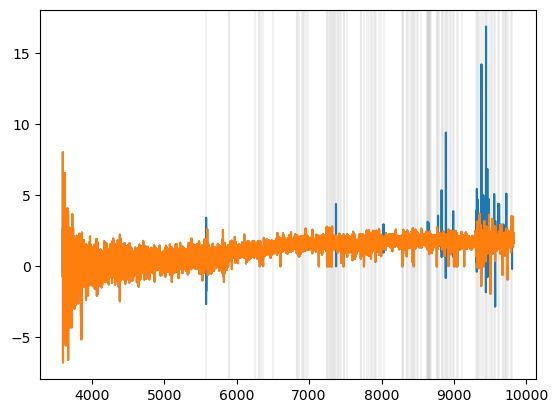

In [12]:
newflux = remove_sky_lines(test_flux, line_idxs, remove_window=2, filter_window=10)

for line in skylines:
    plt.axvline(x=line, color='silver', alpha=0.2)
plt.plot(wave, test_flux)
plt.plot(wave, newflux)
#plt.scatter(wave[idxs], newflux[idxs], marker='x', color='m')
#plt.xlim(7000, 7500)

In [13]:
lenses = lenses[60:70]

In [14]:
#plotting stuff for testing

newaves = []
newfluxes = []

for lens in lenses:
    lens_flux = remove_sky_lines(lens['summed flux'], line_idxs, 3, 50)
    lens_wave, lens_flux, ivar = rebin_flux(lens['wave'], lens_flux, None, nbins=3600)
    #lens_wave = lens['wave']
    lens_flux = median_norm(lens_flux)
    newaves.append(lens_wave)
    newfluxes.append(lens_flux)

newavet = Table()
newfluxt = Table()
newavet['new wave'] = newaves
newfluxt['new fluxes'] = newfluxes

newlenses = hstack([lenses, newavet, newfluxt])

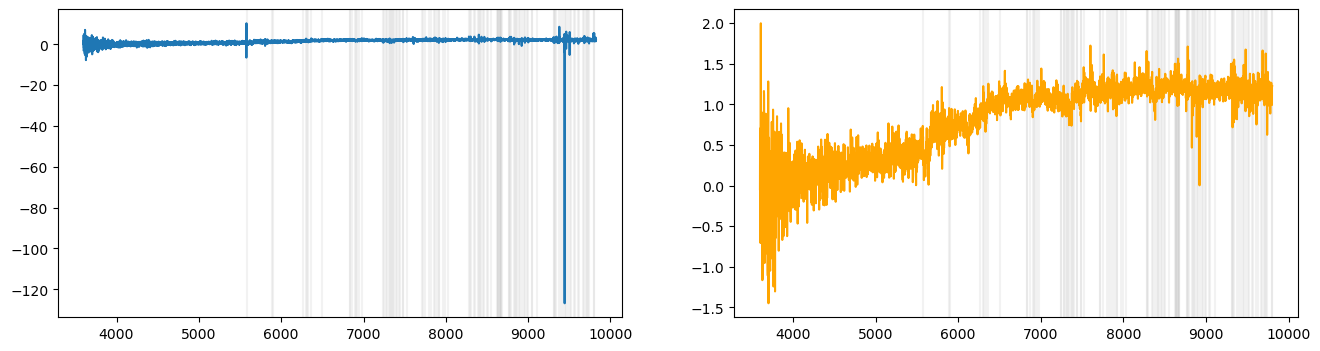

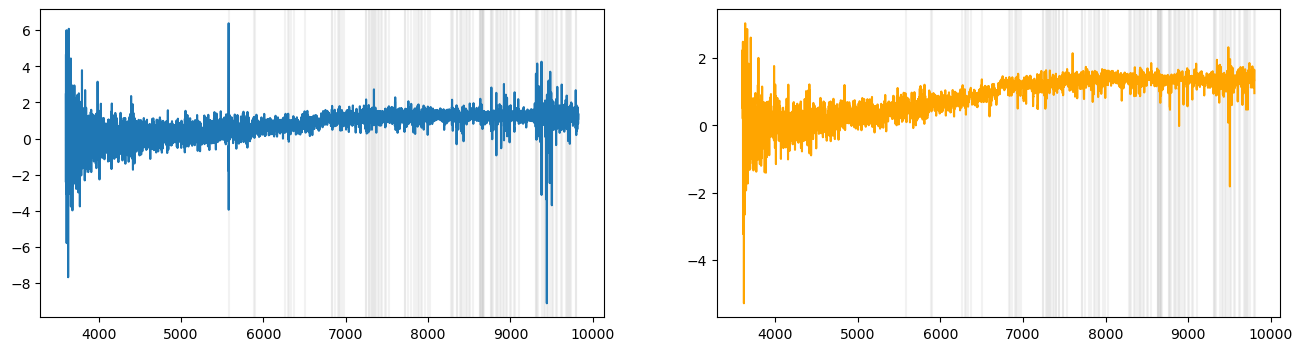

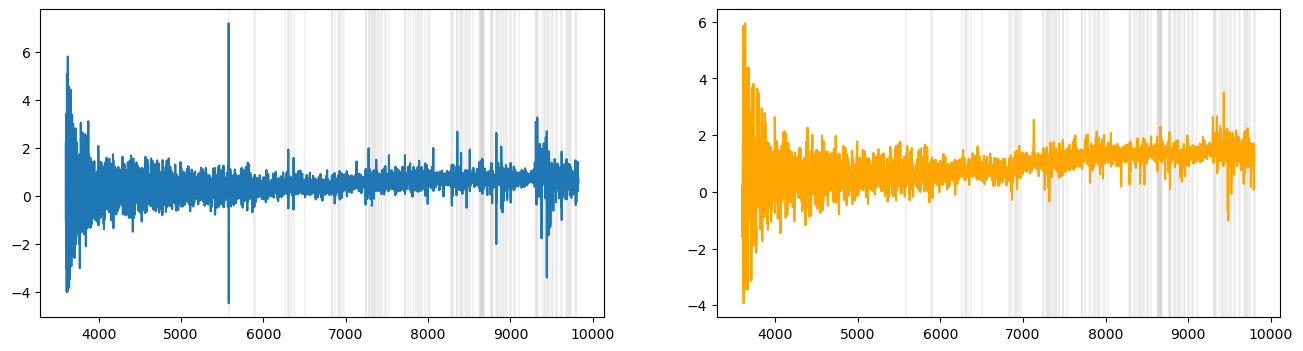

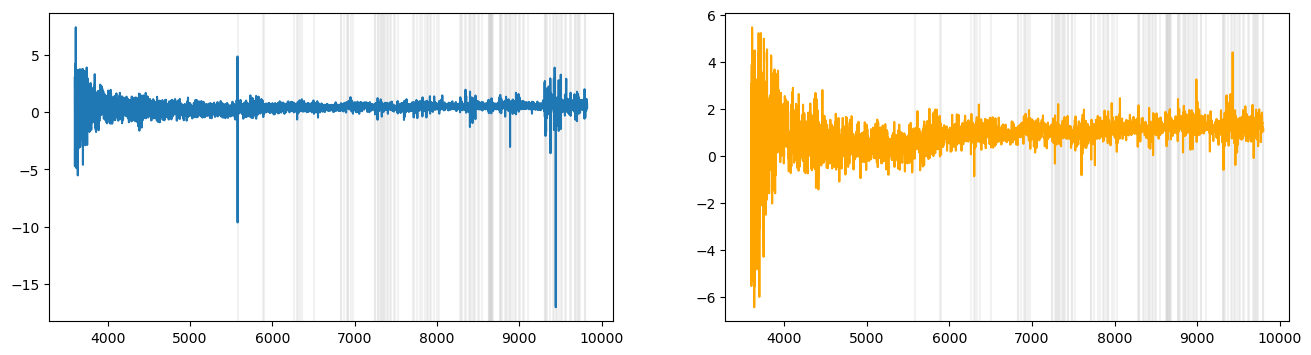

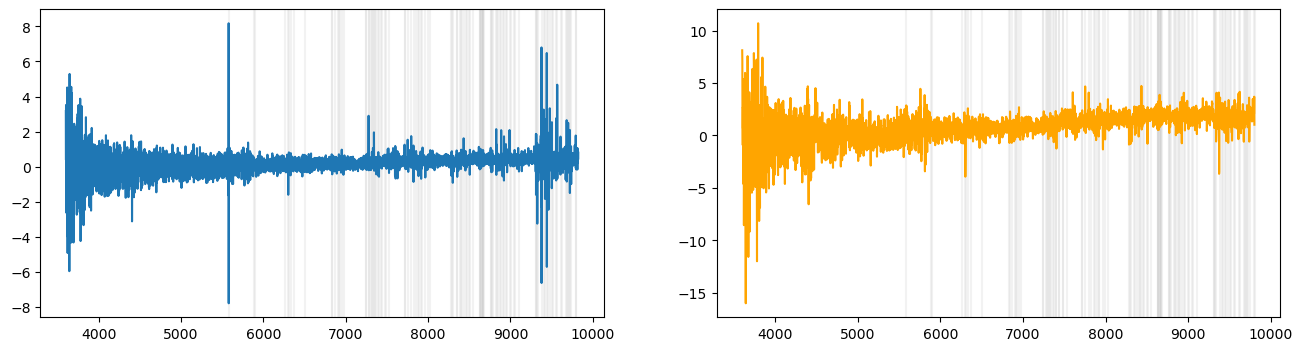

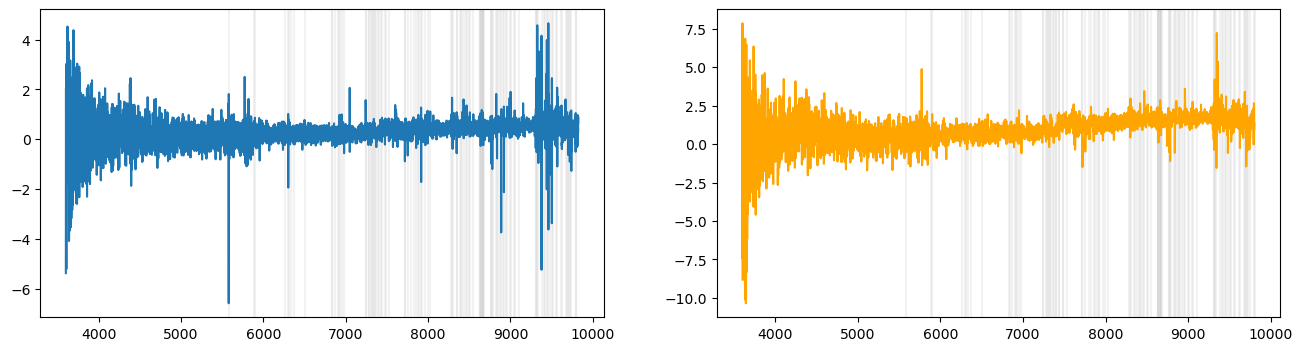

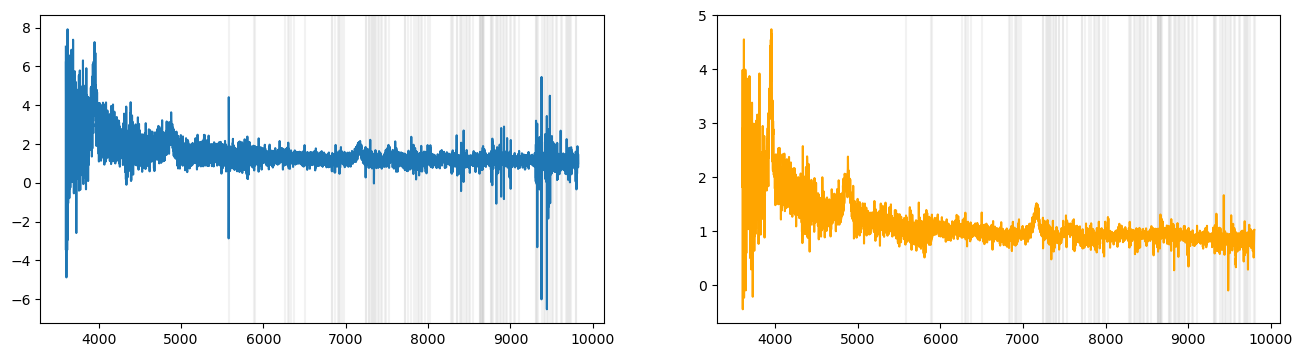

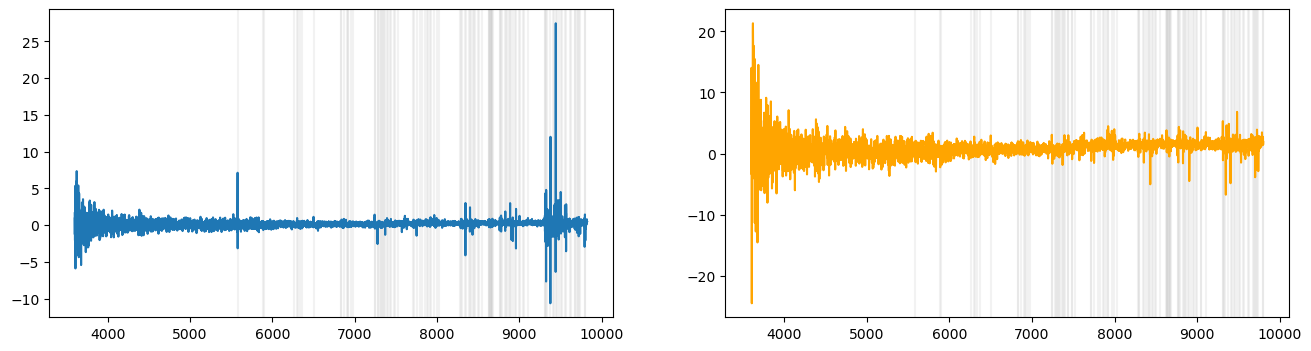

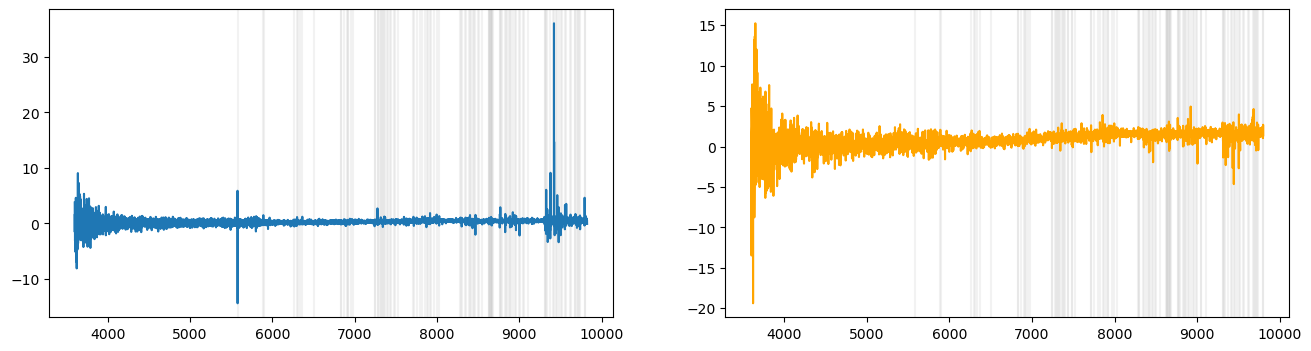

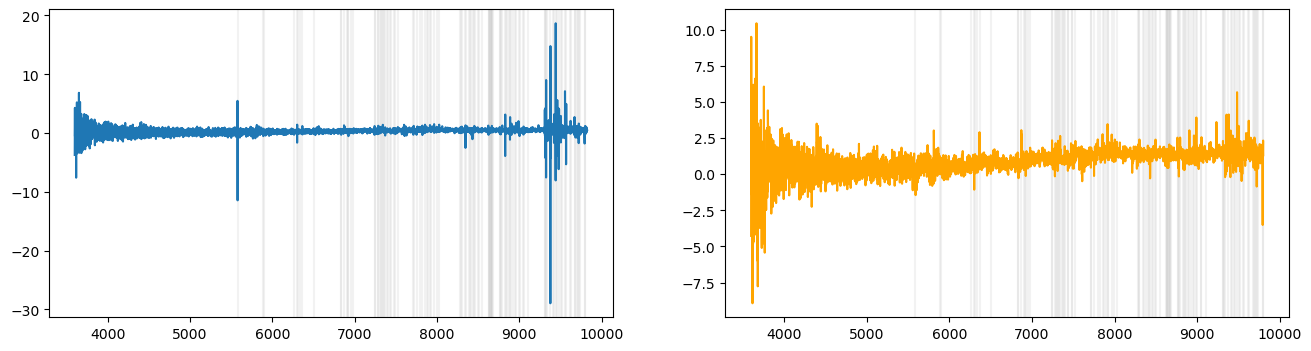

In [17]:
for lens, newlens in zip(lenses, newlenses):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
    for line in skylines:
        ax1.axvline(x=line, color='silver', alpha=0.2)
        ax2.axvline(x=line, color='silver', alpha=0.2)
    ax1.plot(lens['wave'], lens['summed flux'], )
    #ax1.set(xlim=[5570, 5590])
    ax2.plot(newlens['new wave'], newlens['new fluxes'], color='orange')
    #ax2.set(xlim=[5570, 5590])

## Lens Preprocessing

In [11]:
savepath = f'vit/data/'

In [12]:
lenses = Table.read('sim-lenses-10000-zonly-slimmed.fits')
newaves = []
newfluxes = []

for lens in lenses:
    lens_flux = remove_sky_lines(lens['summed flux'], line_idxs, 2, 50)
    lens_wave, lens_flux, ivar = rebin_flux(lens['wave'], lens_flux, None, nbins=3600)
    lens_flux = median_norm(lens_flux)
    newaves.append(lens_wave)
    newfluxes.append(lens_flux)
    

newavet = Table()
newfluxt = Table()
newavet['new wave'] = newaves
newfluxt['new fluxes'] = newfluxes

lenses = hstack([lenses, newavet, newfluxt])


In [13]:
lens_flux = lenses['new fluxes']
lens_flux = lens_flux.data

#lens_flux = to_2d(lens_flux)

In [14]:
#plt.imshow(lens_flux[3])

In [15]:

print(f'\n\n{len(lens_flux)}')



11891


In [16]:
with open(rf'lens_flux-mednorm-noskylines.data', 'wb') as f:
    pickle.dump(lens_flux, f)
    print("Saved lenses!")

Saved lenses!


In [17]:
bground = Table.read('single-background-10000-slimmed.fits')
newaves = []
newfluxes = []

for bg in bground:
    bg_flux = remove_sky_lines(bg['flux'], line_idxs, 2, 50)
    bg_wave, bg_flux, ivar = rebin_flux(bg['wave'], bg_flux, None, nbins=3600)
    bg_flux = median_norm(bg_flux)
    newaves.append(bg_wave)
    newfluxes.append(bg_flux)

newavet = Table()
newfluxt = Table()
newavet['new wave'] = newaves
newfluxt['new fluxes'] = newfluxes

bground = hstack([bground, newavet, newfluxt])

In [18]:
bg_flux = bground['new fluxes']
print(f'\n\n{len(bg_flux)}')
bg_flux = bg_flux.data

#bg_flux = to_2d(bg_flux)

with open(rf'bg_flux-mednorm-noskylines.data', 'wb') as f:
    pickle.dump(bg_flux, f)
    print("Saved background!")



13966
Saved background!


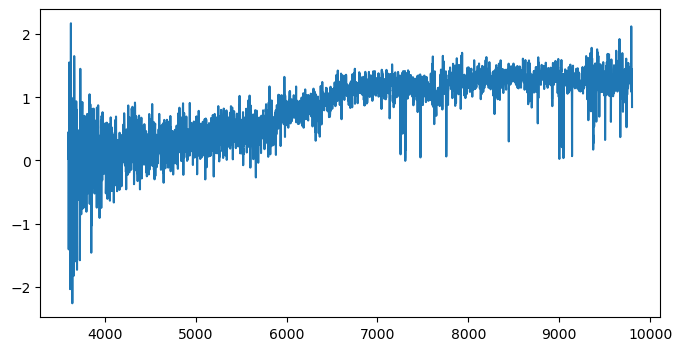

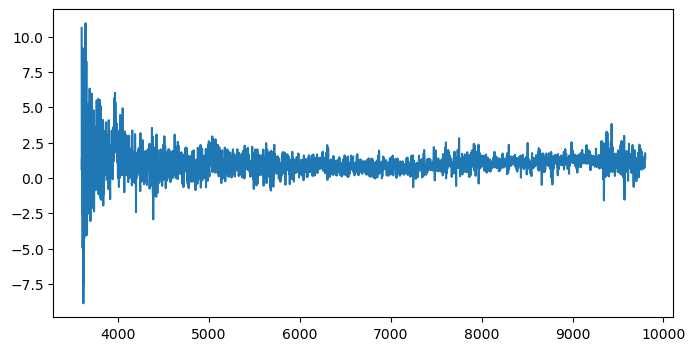

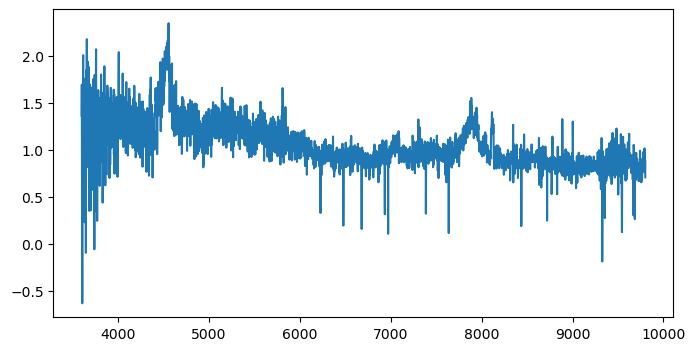

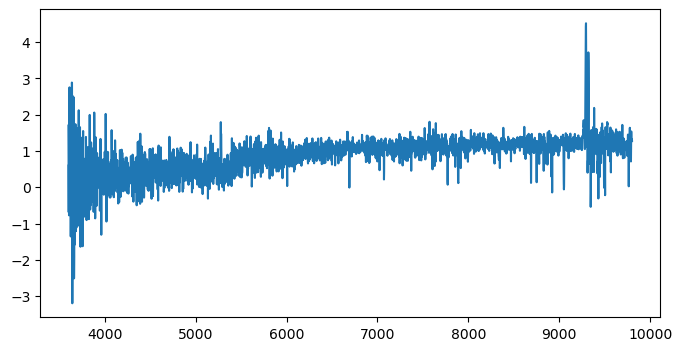

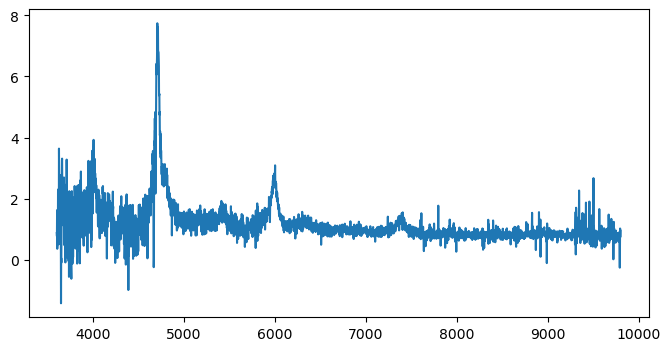

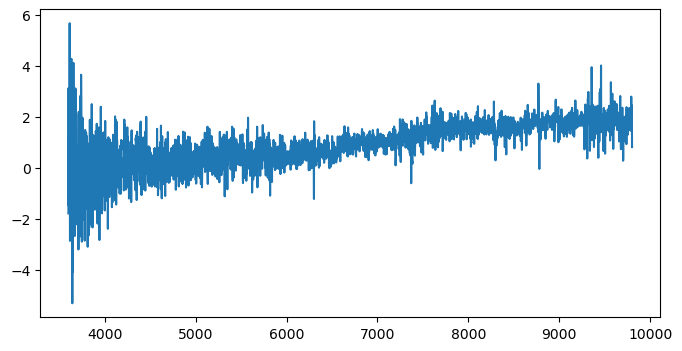

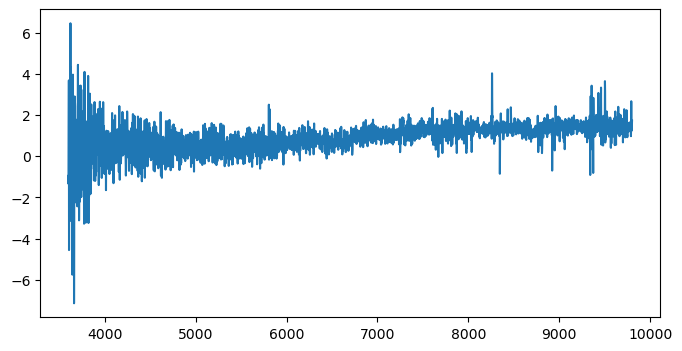

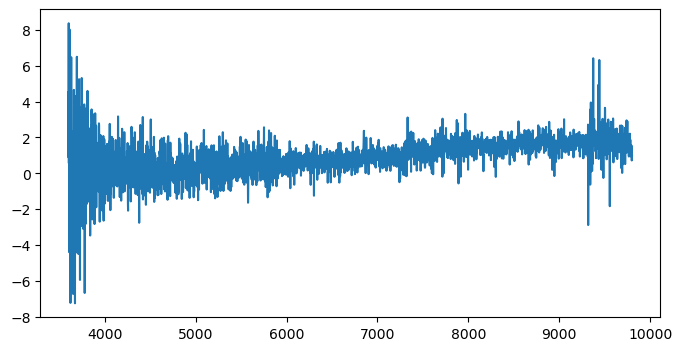

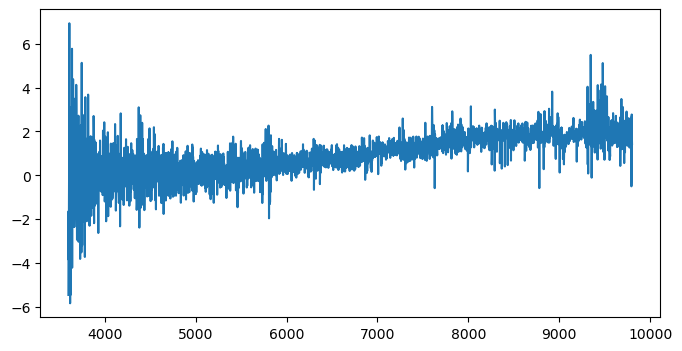

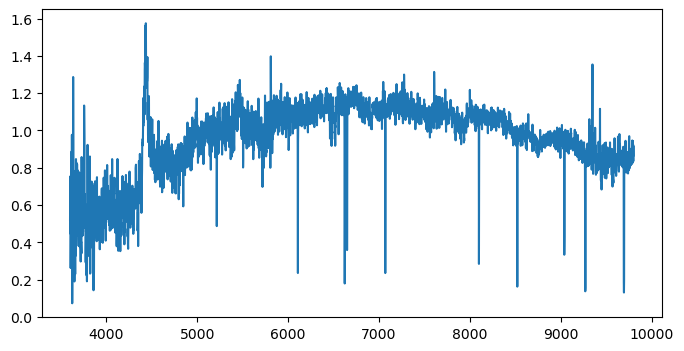

In [19]:
for lens in lenses[100:110]:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(lens['new wave'], lens['new fluxes'])

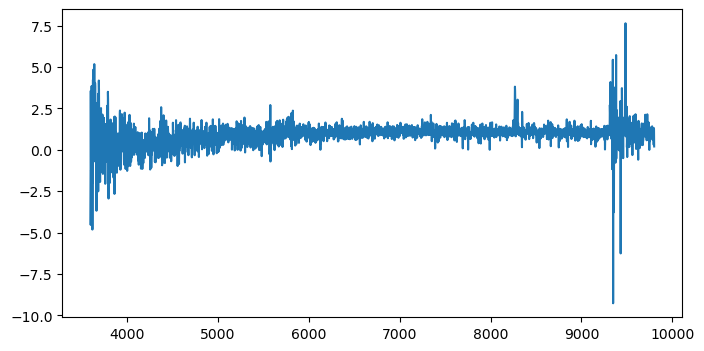

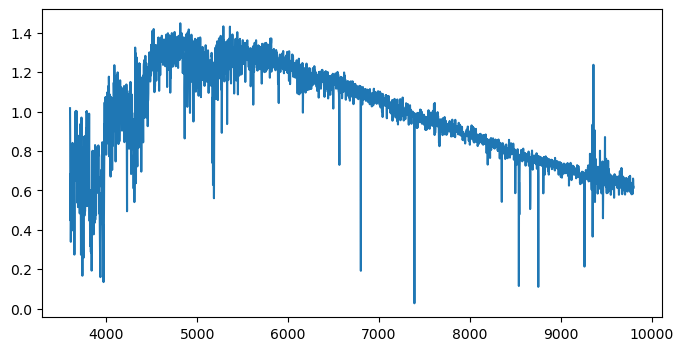

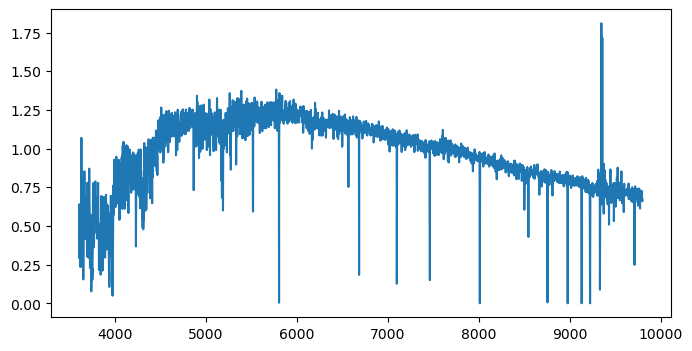

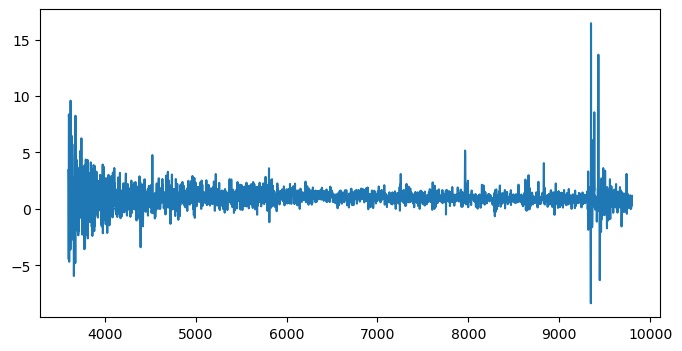

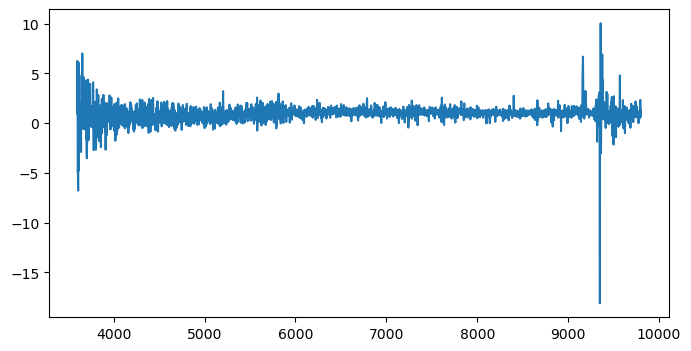

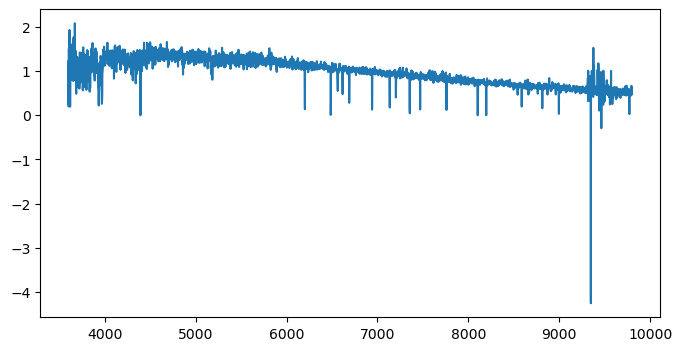

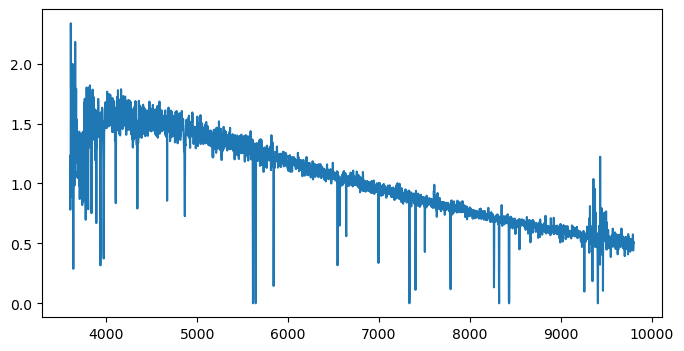

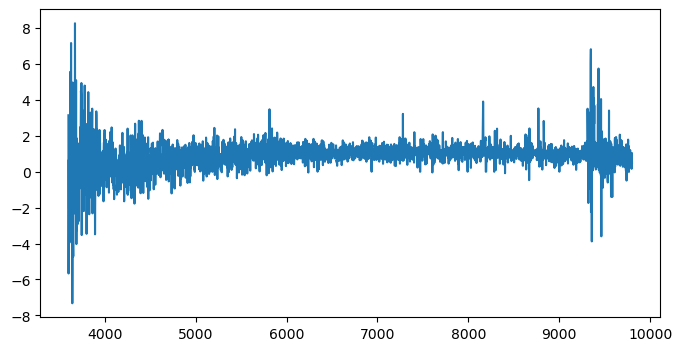

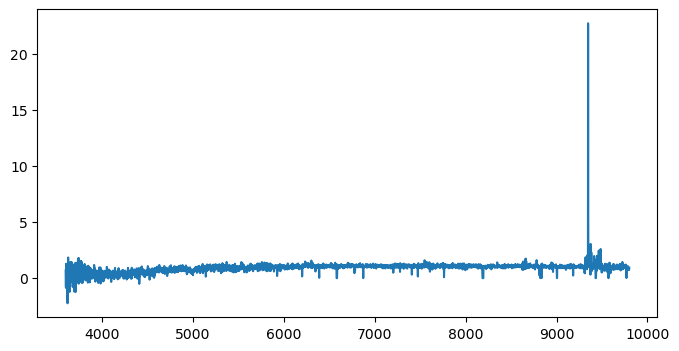

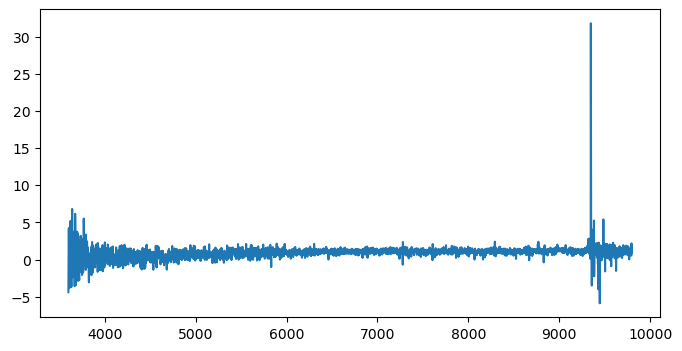

In [21]:
for lens in bground[100:110]:
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(lens['new wave'], lens['new fluxes'])